In [1]:
import os
# import cv2

import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
# Create a custom dataset class
from torchvision.transforms.functional import to_pil_image
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn as nn
import torchvision
from torchvision import models
import os
from glob import glob
import pandas as pd

from PIL import Image
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import DataLoader
import torch.optim as optim

from torchvision import  transforms
import numpy as np


In [4]:
lesion_type_dict = {
        'nv': 'Melanocytic nevi',
        'mel': 'Melanoma',
        'bkl': 'Benign keratosis-like lesions ',
        'bcc': 'Basal cell carcinoma',
        'akiec': 'Actinic keratoses',
        'vasc': 'Vascular lesions',
        'df': 'Dermatofibroma'
    }

In [3]:
IMG_SIZE = 256
transform_train = transforms.Compose(
[
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.RandomHorizontalFlip(),  # Data augmentation: horizontal flip
        transforms.RandomRotation(10),  # Data augmentation: random rotation
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
transform_val = transforms.Compose(
[
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])


In [5]:
def _get_df_data_():
    train_df = pd.read_csv('/kaggle/input/ucidatasplits/train_df.csv').drop(columns=['Unnamed: 0'])
    val_df = pd.read_csv('/kaggle/input/ucidatasplits/val_df.csv').drop(columns=['Unnamed: 0'])
    test_df = pd.read_csv('/kaggle/input/ucidatasplits/test_df.csv').drop(columns=['Unnamed: 0'])
    source = '/kaggle/input/skin-cancer-mnist-ham10000/'

    train_df['image'] = train_df['path'].map(lambda x: transform_train(Image.open(source+x[5:27]+'/'+x[-16:]).convert("RGB")))
    val_df['image'] = val_df['path'].map(lambda x: transform_val(Image.open(source+x[5:27]+'/'+x[-16:]).convert("RGB")))
    test_df['image'] = test_df['path'].map(lambda x: transform_val(Image.open(source+x[5:27]+'/'+x[-16:]).convert("RGB")))
    
    return train_df, val_df, test_df

In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models

# Define the MLP
from torchvision.models import ResNet18_Weights
from transformers import ViTForImageClassification, ViTFeatureExtractor

class ImageEffNet(nn.Module):
    def __init__(self, output_size, num_classes):
        super(ImageEffNet, self).__init__()
        self.net = models.efficientnet_b0(weights='DEFAULT')
        self.net.classifier[1] = nn.Linear(self.net.classifier[1].in_features, output_size)
        self.fc = nn.Linear(output_size, num_classes)

    def forward(self, x):
        x = self.net(x)
        x = self.fc(x)
        return x
    
# class ImageResnet(nn.Module):
#     def __init__(self,  output_size, num_classes):
#         super(ImageResnet, self).__init__()
#         self.net = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
#         # Modify the last layer to output 7 classes
#          #2048
#         num_features = self.net.fc.in_features
#         self.net.fc = nn.Linear(num_features, output_size)
#         self.fc = nn.Linear(output_size, num_classes)

#     def forward(self, x):
#         x = self.net(x)
#         x = self.fc(x)
#         return x

2025-05-01 13:58:35.392272: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-01 13:58:35.392447: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-01 13:58:35.582355: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# we test the which layer weights are different

In [3]:
def _get_model_Eff():
    hidden_size = 128
    output_size = 64
    num_classes = 7
    unet = ImageEffNet(output_size, num_classes)
    return unet
import torch

# Assuming model1 and model2 are the two EfficientNet-B0 models
def compare_models(model1, model2):
    differences = []
    
    # Iterate over both models' named parameters
    for (name1, param1), (name2, param2) in zip(model1.named_parameters(), model2.named_parameters()):
        # Check if the parameter names are the same
        if name1 != name2:
            raise ValueError(f"Layer mismatch: {name1} != {name2}")
        
        # Compare the weights
        if not torch.equal(param1, param2):
            differences.append(name1)
    
    return differences



In [4]:
model2 = _get_model_Eff()  # Load or initialize the second EfficientNet-B0 model
model_path= '/kaggle/input/retrain-model/retrain_eff_combine_model_tune1.pt'
model2.load_state_dict(torch.load(model_path, map_location='cpu')) # 

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 112MB/s] 


<All keys matched successfully>

In [5]:
model2.net.classifier[1]

Linear(in_features=1280, out_features=64, bias=True)

In [5]:
# Example usage:
model1 = ...  # Load or initialize the first EfficientNet-B0 model

model1 = _get_model_Eff()
model_path= '/kaggle/input/tunedmodel/eff_combine_model_tune.pt'
model1.load_state_dict(torch.load(model_path, map_location='cpu')) # 

model2 = _get_model_Eff()  # Load or initialize the second EfficientNet-B0 model
model_path= '/kaggle/input/retrain-model/retrain_eff_combine_model_tune1.pt'
model2.load_state_dict(torch.load(model_path, map_location='cpu')) # 

# Get list of layers with different weights
different_layers = compare_models(model1, model2)

if different_layers:
    print(f"Layers with different weights: {different_layers}")
else:
    print("All layers have the same weights.")


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 99.6MB/s]


Layers with different weights: ['net.features.1.0.block.0.0.weight', 'net.features.1.0.block.0.1.weight', 'net.features.1.0.block.0.1.bias', 'net.features.1.0.block.1.fc1.weight', 'net.features.1.0.block.1.fc1.bias', 'net.features.1.0.block.1.fc2.weight', 'net.features.1.0.block.1.fc2.bias', 'net.features.1.0.block.2.0.weight', 'net.features.1.0.block.2.1.weight', 'net.features.1.0.block.2.1.bias']


# first we tested the untrained model

In [8]:
def _get_model_Eff():
    hidden_size = 128
    output_size = 64
    num_classes = 7
    unet = ImageEffNet(output_size, num_classes)
    return unet


# def _get_model_res():
#     hidden_size = 128
#     output_size = 64
#     num_classes = 7
#     unet = ImageResnet(output_size, num_classes)

#     return unet

In [9]:
train_df, val_df, test_df = _get_df_data_()

In [13]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)
print(train_df.shape[0] + val_df.shape[0]+ test_df.shape[0])
print(train_df.shape[0]/ (train_df.shape[0] + val_df.shape[0]+ test_df.shape[0]))
print( val_df.shape[0]/ (train_df.shape[0] + val_df.shape[0]+ test_df.shape[0]))

def retrain_perform():
    BATCH_SIZE = 32
    from torch.utils.data import DataLoader, WeightedRandomSampler
    from collections import Counter
    # Compute class weights for imbalanced dataset
    class_counts = Counter([label for label in train_df['cell_type_idx']])
    class_weights = {class_id: 1.0 / count for class_id, count in class_counts.items()}
    sample_weights = [class_weights[label] for label in train_df['cell_type_idx']]
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)


    image_source = '/kaggle/input/skin-cancer-mnist-ham10000/'
    train_data = dataMedicalImage(train_df, image_folder= image_source, transform=transform_train)
    val_data = dataMedicalImage(val_df,image_folder= image_source,  transform=transform_val)
    test_data = dataMedicalImage(test_df, image_folder= image_source, transform=transform_val)
    
    # Data loaders
    trainloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, sampler=sampler)
    valloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
    testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

    print(f"Total number of batches in Train Loader: {len(trainloader)}")
    print(f"Total number of batches in Val Loader: {len(valloader)}")

    model2 = _get_model_Eff()  # Load or initialize the second EfficientNet-B0 model
    model_path= '/kaggle/input/retrain-model/retrain_eff_combine_model_tune1.pt'
    model2.load_state_dict(torch.load(model_path)) #, map_location='cpu'
    
    test_model(model2, testloader)
retrain_perform()

(5229, 11)
(1120, 11)
(1121, 11)
7470
0.7
0.1499330655957162
Total number of batches in Train Loader: 164
Total number of batches in Val Loader: 35
Current accuracy is: 87.24%
Classification Report:
               precision    recall  f1-score   support

          nv       0.62      0.71      0.66        34
         mel       0.84      0.88      0.86        49
         bkl       0.70      0.71      0.70       109
         bcc       0.56      0.45      0.50        11
       akiec       0.95      0.93      0.94       811
        vasc       0.61      0.62      0.61        92
          df       0.65      1.00      0.79        15

    accuracy                           0.87      1121
   macro avg       0.70      0.76      0.72      1121
weighted avg       0.88      0.87      0.87      1121

Confusion Matrix:
 [[ 24   0   5   0   2   2   1]
 [  2  43   1   0   2   0   1]
 [  5   3  77   2  14   8   0]
 [  2   1   1   5   1   0   1]
 [  3   2  18   0 757  27   4]
 [  3   2   8   2  19  57   1

In [10]:
class dataMedicalImage(Dataset):
    def __init__(self, dataframe, image_folder=None, transform=None):
        self.dataframe = dataframe
        self.folder = image_folder
        self.transform = transform # already used on df-image creation process

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image = self.dataframe.iloc[idx]['image']
        label = self.dataframe.iloc[idx]['cell_type_idx']  # Assuming the label is in the second column
        
        return image, int(label)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def test_model(model, data_loader, class_names = lesion_type_dict.keys()):
    model.eval()
    model.to(device)
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate accuracy
    acc = 100 * sum(np.array(all_predictions) == np.array(all_labels)) / len(all_labels)
    print('Current accuracy is: {:.2f}%'.format(acc))

    # Generate classification report
    report = classification_report(all_labels, all_predictions, target_names=class_names)
    print("Classification Report:\n", report)

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    print("Confusion Matrix:\n", cm)

    # # Plot confusion matrix
#     plt.figure(figsize=(10, 7))
#     sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
#     plt.xlabel('Predicted')
#     plt.ylabel('True')
#     plt.title('Confusion Matrix')
#     plt.show()

    return acc
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Training function
def train_model(model, dataloader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, label in dataloader:
            optimizer.zero_grad()
            images = images.to(device)
            label = label.to(device)
            outputs = model(images)
            loss = criterion(outputs, label)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(dataloader)
        print(f"Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss}")

    return model


# Function to evaluate the model
def eval_model(model, data_loader):
    total, correct = 0, 0
    model.eval()

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        acc = 100 * correct / total
    print('current accuracy is ', acc)
    return acc

# this is retrain this old model

In [17]:
def main_eff_retrain(model = None, name='test', r_laye= 1):
    # Hyperparameters
    num_epochs_mlp = 1
    num_epochs_total = 10  # Total epochs including both MLP and U-Net
    learning_rate = 0.001
    BATCH_SIZE = 32

    # Now you can train the model on your dataset
    model = model.to('cuda' if torch.cuda.is_available() else 'cpu')
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
#   this is for tune only, 1 and 2, the follows is only tune 
#     optimizer = optim.Adam(model.net.features[r_laye].parameters(), lr=1e-4)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
#     optimizer = optim.Adam(
#     list(model.net.features[1].parameters()) + list(model.net.features[2].parameters()), 
#     lr=1e-4)
    
    from torch.utils.data import DataLoader, WeightedRandomSampler
    from collections import Counter
    # Compute class weights for imbalanced dataset
    class_counts = Counter([label for label in train_df['cell_type_idx']])
    class_weights = {class_id: 1.0 / count for class_id, count in class_counts.items()}
    sample_weights = [class_weights[label] for label in train_df['cell_type_idx']]
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)


    image_source = '/kaggle/input/skin-cancer-mnist-ham10000/'
    train_data = dataMedicalImage(train_df, image_folder= image_source, transform=transform_train)
    val_data = dataMedicalImage(val_df,image_folder= image_source,  transform=transform_val)
    test_data = dataMedicalImage(test_df, image_folder= image_source, transform=transform_val)
    
    # Data loaders
    trainloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, sampler=sampler)
    valloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
    testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

    print(f"Total number of batches in Train Loader: {len(trainloader)}")
    print(f"Total number of batches in Val Loader: {len(valloader)}")

    best_model = None
    accf = 0
    test_model(model, testloader)
    
    for epoch in range(0, num_epochs_total, 1):
        # Train MLP for 10 epochs
        model = train_model(model, trainloader, criterion, optimizer, num_epochs_mlp)

        acc = eval_model(model, valloader)
        if acc > accf:
            accf = acc
            best_model = model
            torch.save(best_model.state_dict(), 'retrain_eff_old_model_'+name+'.pt')
    test_model(best_model, testloader)
    

In [13]:
def retrain_model_eff(name='', layid = 1):
    model_eff = _get_model_Eff()
    # retune the first one
    model_path= '/kaggle/input/tunedmodel/eff_combine_model_tune.pt'
    model_eff.load_state_dict(torch.load(model_path)) # , map_location='cpu'

    # Freeze all parameters
    for param in model_eff.net.parameters():
        param.requires_grad = False

    # Unfreeze only the parameters of the specific layer you want to tune
    for param in model_eff.net.features[layid].parameters():
        param.requires_grad = True
    
    main_eff_retrain(model = model_eff, name=('model_eff1'+name), r_laye= layid)

In [18]:
def retrain_model_all(name='', layid = 1):
    model_eff = _get_model_Eff()
    # retune the first one
    main_eff_retrain(model = model_eff, name=('model_eff1'+name), r_laye= layid)
     
import time
start_time = time.time()

retrain_model_all(name='', layid = 1)  
print("--- %s seconds ---" % (time.time() - start_time))

Total number of batches in Train Loader: 164
Total number of batches in Val Loader: 35
Current accuracy is: 2.32%
Classification Report:
               precision    recall  f1-score   support

          nv       0.02      0.12      0.04        34
         mel       0.00      0.00      0.00        49
         bkl       0.00      0.00      0.00       109
         bcc       0.00      0.00      0.00        11
       akiec       0.00      0.00      0.00       811
        vasc       0.09      0.11      0.10        92
          df       0.01      0.80      0.03        15

    accuracy                           0.02      1121
   macro avg       0.02      0.15      0.02      1121
weighted avg       0.01      0.02      0.01      1121

Confusion Matrix:
 [[  4   0   0   0   0   2  28]
 [  5   0   0   0   0   0  44]
 [ 12   1   0   0   0   4  92]
 [  0   0   0   0   0   1  10]
 [134   2   1   0   0  91 583]
 [  8   0   0   0   0  10  74]
 [  3   0   0   0   0   0  12]]


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 0/0, Loss: 1.044206932368802
current accuracy is  72.94642857142857
Epoch 0/0, Loss: 0.32953269161829135
current accuracy is  79.28571428571429
Epoch 0/0, Loss: 0.20519960405895624
current accuracy is  79.46428571428571
Epoch 0/0, Loss: 0.13409958372642172
current accuracy is  82.32142857142857
Epoch 0/0, Loss: 0.10121991558045876
current accuracy is  83.39285714285714
Epoch 0/0, Loss: 0.09114196706313367
current accuracy is  84.375
Epoch 0/0, Loss: 0.06972247411826307
current accuracy is  85.0
Epoch 0/0, Loss: 0.05906176533856679
current accuracy is  86.33928571428571
Epoch 0/0, Loss: 0.04261758338898511
current accuracy is  86.33928571428571
Epoch 0/0, Loss: 0.05412322893119758
current accuracy is  86.33928571428571
Current accuracy is: 86.53%
Classification Report:
               precision    recall  f1-score   support

          nv       0.78      0.41      0.54        34
         mel       0.80      0.80      0.80        49
         bkl       0.74      0.64      0.69       1

test time

october 20

CALCULATE TIME

this is results

87.24 + 86.17  + 86.26+85.99+87.15+86.98+86.80+86.62+86.44

change model, fixed all other layers and set free only on one layer

model load and change

# effnet retrain--

In [15]:
def main_eff_retrain(model = None, name='test', r_laye= 1):
    # Hyperparameters
    num_epochs_mlp = 1
    num_epochs_total = 10  # Total epochs including both MLP and U-Net
    learning_rate = 0.001
    BATCH_SIZE = 32

    # Now you can train the model on your dataset
    model = model.to('cuda' if torch.cuda.is_available() else 'cpu')
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
#   this is for tune only, 1 and 2, the follows is only tune 
    optimizer = optim.Adam(model.net.features[r_laye].parameters(), lr=1e-4)
#     optimizer = optim.Adam(
#     list(model.net.features[1].parameters()) + list(model.net.features[2].parameters()), 
#     lr=1e-4)
    
    from torch.utils.data import DataLoader, WeightedRandomSampler
    from collections import Counter
    # Compute class weights for imbalanced dataset
    class_counts = Counter([label for label in train_df['cell_type_idx']])
    class_weights = {class_id: 1.0 / count for class_id, count in class_counts.items()}
    sample_weights = [class_weights[label] for label in train_df['cell_type_idx']]
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)


    image_source = '/kaggle/input/skin-cancer-mnist-ham10000/'
    train_data = dataMedicalImage(train_df, image_folder= image_source, transform=transform_train)
    val_data = dataMedicalImage(val_df,image_folder= image_source,  transform=transform_val)
    test_data = dataMedicalImage(test_df, image_folder= image_source, transform=transform_val)
    
    # Data loaders
    trainloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, sampler=sampler)
    valloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
    testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

    print(f"Total number of batches in Train Loader: {len(trainloader)}")
    print(f"Total number of batches in Val Loader: {len(valloader)}")

    best_model = None
    accf = 0
    test_model(model, testloader)
    
    for epoch in range(0, num_epochs_total, 1):
        # Train MLP for 10 epochs
        model = train_model(model, trainloader, criterion, optimizer, num_epochs_mlp)

        acc = eval_model(model, valloader)
        if acc > accf:
            accf = acc
            best_model = model
            torch.save(best_model.state_dict(), 'retrain_eff_model_'+name+'.pt')
    test_model(best_model, testloader)
    

start retrain

In [16]:
def retrain_model_eff(name='', layid = 1):
    model_eff = _get_model_Eff()
    # retune the first one
    model_path= '/kaggle/input/retrainedmodelsep27/firsttrain_eff_model_f1v1.pt'
    model_eff.load_state_dict(torch.load(model_path)) # , map_location='cpu'

    # Freeze all parameters
    for param in model_eff.net.parameters():
        param.requires_grad = False

    # Unfreeze only the parameters of the specific layer you want to tune
    for param in model_eff.net.features[layid].parameters():
        param.requires_grad = True
    
    main_eff_retrain(model = model_eff, name=('model_eff1'+name), r_laye= layid)

In [24]:
retrain_model_eff(name='v1', layid = 1)

Total number of batches in Train Loader: 164
Total number of batches in Val Loader: 35
Current accuracy is: 85.99%
Classification Report:
               precision    recall  f1-score   support

          nv       0.78      0.53      0.63        34
         mel       0.83      0.80      0.81        49
         bkl       0.60      0.80      0.68       109
         bcc       0.67      0.55      0.60        11
       akiec       0.95      0.92      0.94       811
        vasc       0.54      0.54      0.54        92
          df       0.93      0.93      0.93        15

    accuracy                           0.86      1121
   macro avg       0.76      0.72      0.73      1121
weighted avg       0.87      0.86      0.86      1121

Confusion Matrix:
 [[ 18   0  11   0   4   1   0]
 [  2  39   4   1   3   0   0]
 [  2   3  87   0   8   9   0]
 [  0   2   1   6   1   1   0]
 [  0   1  27   1 750  32   0]
 [  1   2  16   0  22  50   1]
 [  0   0   0   1   0   0  14]]
Epoch 0/0, Loss: 0.19048132

In [25]:
retrain_model_eff(name='v1', layid = 2)

Total number of batches in Train Loader: 164
Total number of batches in Val Loader: 35
Current accuracy is: 85.99%
Classification Report:
               precision    recall  f1-score   support

          nv       0.78      0.53      0.63        34
         mel       0.83      0.80      0.81        49
         bkl       0.60      0.80      0.68       109
         bcc       0.67      0.55      0.60        11
       akiec       0.95      0.92      0.94       811
        vasc       0.54      0.54      0.54        92
          df       0.93      0.93      0.93        15

    accuracy                           0.86      1121
   macro avg       0.76      0.72      0.73      1121
weighted avg       0.87      0.86      0.86      1121

Confusion Matrix:
 [[ 18   0  11   0   4   1   0]
 [  2  39   4   1   3   0   0]
 [  2   3  87   0   8   9   0]
 [  0   2   1   6   1   1   0]
 [  0   1  27   1 750  32   0]
 [  1   2  16   0  22  50   1]
 [  0   0   0   1   0   0  14]]
Epoch 0/0, Loss: 0.18054940

In [26]:
print('this is layer 3')
retrain_model_eff(name='v1', layid = 3)

this is layer 3
Total number of batches in Train Loader: 164
Total number of batches in Val Loader: 35
Current accuracy is: 85.99%
Classification Report:
               precision    recall  f1-score   support

          nv       0.78      0.53      0.63        34
         mel       0.83      0.80      0.81        49
         bkl       0.60      0.80      0.68       109
         bcc       0.67      0.55      0.60        11
       akiec       0.95      0.92      0.94       811
        vasc       0.54      0.54      0.54        92
          df       0.93      0.93      0.93        15

    accuracy                           0.86      1121
   macro avg       0.76      0.72      0.73      1121
weighted avg       0.87      0.86      0.86      1121

Confusion Matrix:
 [[ 18   0  11   0   4   1   0]
 [  2  39   4   1   3   0   0]
 [  2   3  87   0   8   9   0]
 [  0   2   1   6   1   1   0]
 [  0   1  27   1 750  32   0]
 [  1   2  16   0  22  50   1]
 [  0   0   0   1   0   0  14]]
Epoch 0/0, 

In [27]:
print('this is layer 4')
retrain_model_eff(name='v1', layid = 4)

this is layer 3
Total number of batches in Train Loader: 164
Total number of batches in Val Loader: 35
Current accuracy is: 85.99%
Classification Report:
               precision    recall  f1-score   support

          nv       0.78      0.53      0.63        34
         mel       0.83      0.80      0.81        49
         bkl       0.60      0.80      0.68       109
         bcc       0.67      0.55      0.60        11
       akiec       0.95      0.92      0.94       811
        vasc       0.54      0.54      0.54        92
          df       0.93      0.93      0.93        15

    accuracy                           0.86      1121
   macro avg       0.76      0.72      0.73      1121
weighted avg       0.87      0.86      0.86      1121

Confusion Matrix:
 [[ 18   0  11   0   4   1   0]
 [  2  39   4   1   3   0   0]
 [  2   3  87   0   8   9   0]
 [  0   2   1   6   1   1   0]
 [  0   1  27   1 750  32   0]
 [  1   2  16   0  22  50   1]
 [  0   0   0   1   0   0  14]]
Epoch 0/0, 

train on the second

main_eff definition

# this is retrain reenet new models, 

In [51]:
def main_res_retrain(model=None, name='', layid = 1):
    # Hyperparameters
    num_epochs_mlp = 1
    num_epochs_total = 10  # Total epochs including both MLP and U-Net
    learning_rate = 0.001
    BATCH_SIZE = 32
    IMG_SIZE = 256

    model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.net.layer1.parameters(), lr=1e-4)

    from torch.utils.data import DataLoader, WeightedRandomSampler
    from collections import Counter
    # Compute class weights for imbalanced dataset
    class_counts = Counter([label for label in train_df['cell_type_idx']])
    class_weights = {class_id: 1.0 / count for class_id, count in class_counts.items()}
    sample_weights = [class_weights[label] for label in train_df['cell_type_idx']]
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)


    image_source = '/kaggle/input/skin-cancer-mnist-ham10000/'
    train_data = dataMedicalImage(train_df, image_folder= image_source, transform=transform_train)
    val_data = dataMedicalImage(val_df,image_folder= image_source,  transform=transform_val)
    test_data = dataMedicalImage(test_df, image_folder= image_source, transform=transform_val)
    
    # Data loaders
    trainloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, sampler=sampler)
    valloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
    testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

    print(f"Total number of batches in Train Loader: {len(trainloader)}")
    print(f"Total number of batches in Val Loader: {len(valloader)}")

    best_model = None
    accf = 0
    print('first test original ')
    test_model(model, testloader)
    for epoch in range(0, num_epochs_total, 1):
        # Train MLP for 10 epochs
        model = train_model(model, trainloader, criterion, optimizer, num_epochs_mlp)

        acc = eval_model(model, valloader)
        if acc > accf:
            accf = acc
            best_model = model
            torch.save(best_model.state_dict(), 'retrain_resnet_model_'+name+'.pt')

    test_model(best_model, testloader)
    
def retrain_model_res1(name='', layid = 1):
    model_res = _get_model_res()
    # retune the first one
    model_path= '/kaggle/input/retrainedmodelsep27/firsttrain_resnet_model__f1v2.pt'
    model_res.load_state_dict(torch.load(model_path)) # , map_location='cpu'

    for param in model_res.net.parameters():
        param.requires_grad = False
    _nid = 'layer'+str(layid)
    # Unfreeze only the parameters of the specific layer you want to tune
    for param in model_res.net.layer1.parameters():
        param.requires_grad = True
    # Freeze all parameters
    
    main_res_retrain(model = model_res, name=('model_res1'+name), layid= layid)    

In [37]:

print('this is v1 layer 1-1')
retrain_model_res1(name='v1-L1-1', layid = 1)
print('this is v1 layer 1-2')
retrain_model_res1(name='v1-L1-2', layid = 1)
print('this is v1 layer 1-3')
retrain_model_res1(name='v1-L1-3', layid = 1)

this is v1 layer 1-1
Total number of batches in Train Loader: 164
Total number of batches in Val Loader: 35
first test original 
Current accuracy is: 81.45%
Classification Report:
               precision    recall  f1-score   support

          nv       0.45      0.41      0.43        34
         mel       0.71      0.65      0.68        49
         bkl       0.54      0.67      0.60       109
         bcc       0.83      0.45      0.59        11
       akiec       0.91      0.91      0.91       811
        vasc       0.44      0.38      0.41        92
          df       0.92      0.80      0.86        15

    accuracy                           0.81      1121
   macro avg       0.69      0.61      0.64      1121
weighted avg       0.82      0.81      0.81      1121

Confusion Matrix:
 [[ 14   3   7   0   8   2   0]
 [  6  32   2   0   6   3   0]
 [  0   4  73   0  20  12   0]
 [  0   1   2   5   2   0   1]
 [  3   4  34   1 742  27   0]
 [  8   1  17   0  31  35   0]
 [  0   0   0   0

In [28]:
main_res(model=model, name='layer3')

Total number of batches in Train Loader: 164
Total number of batches in Val Loader: 35
first test original 
Current accuracy is: 85.82%
Classification Report:
               precision    recall  f1-score   support

          nv       0.64      0.53      0.58        34
         mel       0.76      0.76      0.76        49
         bkl       0.69      0.69      0.69       109
         bcc       1.00      0.36      0.53        11
       akiec       0.91      0.96      0.94       811
        vasc       0.58      0.41      0.48        92
          df       0.85      0.73      0.79        15

    accuracy                           0.86      1121
   macro avg       0.78      0.63      0.68      1121
weighted avg       0.85      0.86      0.85      1121

Confusion Matrix:
 [[ 18   4   6   0   4   2   0]
 [  3  37   3   0   5   0   1]
 [  5   2  75   0  18   9   0]
 [  0   1   1   4   5   0   0]
 [  1   1  13   0 779  17   0]
 [  1   2  10   0  40  38   1]
 [  0   2   0   0   2   0  11]]
Epoch 

In [32]:
main_res(model=model, name='layer2')

Total number of batches in Train Loader: 164
Total number of batches in Val Loader: 35
first test original 
Current accuracy is: 85.82%
Classification Report:
               precision    recall  f1-score   support

          nv       0.64      0.53      0.58        34
         mel       0.76      0.76      0.76        49
         bkl       0.69      0.69      0.69       109
         bcc       1.00      0.36      0.53        11
       akiec       0.91      0.96      0.94       811
        vasc       0.58      0.41      0.48        92
          df       0.85      0.73      0.79        15

    accuracy                           0.86      1121
   macro avg       0.78      0.63      0.68      1121
weighted avg       0.85      0.86      0.85      1121

Confusion Matrix:
 [[ 18   4   6   0   4   2   0]
 [  3  37   3   0   5   0   1]
 [  5   2  75   0  18   9   0]
 [  0   1   1   4   5   0   0]
 [  1   1  13   0 779  17   0]
 [  1   2  10   0  40  38   1]
 [  0   2   0   0   2   0  11]]
Epoch 

In [40]:
main_res(model=model, name='1and2')

Total number of batches in Train Loader: 164
Total number of batches in Val Loader: 35
first test original 
Current accuracy is: 85.82%
Classification Report:
               precision    recall  f1-score   support

          nv       0.64      0.53      0.58        34
         mel       0.76      0.76      0.76        49
         bkl       0.69      0.69      0.69       109
         bcc       1.00      0.36      0.53        11
       akiec       0.91      0.96      0.94       811
        vasc       0.58      0.41      0.48        92
          df       0.85      0.73      0.79        15

    accuracy                           0.86      1121
   macro avg       0.78      0.63      0.68      1121
weighted avg       0.85      0.86      0.85      1121

Confusion Matrix:
 [[ 18   4   6   0   4   2   0]
 [  3  37   3   0   5   0   1]
 [  5   2  75   0  18   9   0]
 [  0   1   1   4   5   0   0]
 [  1   1  13   0 779  17   0]
 [  1   2  10   0  40  38   1]
 [  0   2   0   0   2   0  11]]
Epoch 

In [44]:
main_res(model=model, name='layer4')

Total number of batches in Train Loader: 164
Total number of batches in Val Loader: 35
first test original 
Current accuracy is: 85.82%
Classification Report:
               precision    recall  f1-score   support

          nv       0.64      0.53      0.58        34
         mel       0.76      0.76      0.76        49
         bkl       0.69      0.69      0.69       109
         bcc       1.00      0.36      0.53        11
       akiec       0.91      0.96      0.94       811
        vasc       0.58      0.41      0.48        92
          df       0.85      0.73      0.79        15

    accuracy                           0.86      1121
   macro avg       0.78      0.63      0.68      1121
weighted avg       0.85      0.86      0.85      1121

Confusion Matrix:
 [[ 18   4   6   0   4   2   0]
 [  3  37   3   0   5   0   1]
 [  5   2  75   0  18   9   0]
 [  0   1   1   4   5   0   0]
 [  1   1  13   0 779  17   0]
 [  1   2  10   0  40  38   1]
 [  0   2   0   0   2   0  11]]
Epoch 

check the feature size

# model analysis by weightwatcher

[weightwatcher tool](https://github.com/CalculatedContent/WeightWatcher)

In [1]:
pip install weightwatcher

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.7 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models
import weightwatcher as ww
import torchvision.models as models


# Define the MLP
from torchvision.models import ResNet18_Weights
from transformers import ViTForImageClassification, ViTFeatureExtractor

class ImageEffNet(nn.Module):
    def __init__(self, output_size, num_classes):
        super(ImageEffNet, self).__init__()
        self.net = models.efficientnet_b0(weights='DEFAULT')
        self.net.classifier[1] = nn.Linear(self.net.classifier[1].in_features, output_size)
        self.fc = nn.Linear(output_size, num_classes)

    def forward(self, x):
        x = self.net(x)
        x = self.fc(x)
        return x
    
class ImageResnet(nn.Module):
    def __init__(self,  output_size, num_classes):
        super(ImageResnet, self).__init__()
        self.net = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        # Modify the last layer to output 7 classes
         #2048
        num_features = self.net.fc.in_features
        self.net.fc = nn.Linear(num_features, output_size)
        self.fc = nn.Linear(output_size, num_classes)

    def forward(self, x):
        x = self.net(x)
        x = self.fc(x)
        return x

2024-10-04 08:44:50.011760: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-04 08:44:50.011950: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-04 08:44:50.192875: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
def _get_model_Eff():
    hidden_size = 128
    output_size = 64
    num_classes = 7
    unet = ImageEffNet(output_size, num_classes)
    # get the fine tune one-time model to see which layer is well-tuned or not
    model_path= '/kaggle/input/tunedmodel/eff_combine_model_tune.pt'
    unet.load_state_dict(torch.load(model_path, map_location='cpu')) # , map_location='cpu'
    return unet


def _get_model_res():
    hidden_size = 128
    output_size = 64
    num_classes = 7
    model = ImageResnet(output_size, num_classes)
    #  get the fine tune one-time model to see which layer is well-tuned or not
    model_path= '/kaggle/input/tunedmodel/res_combine_model_tune.pt'
    model.load_state_dict(torch.load(model_path, map_location='cpu')) # 
    return model

In [4]:
def eff_analyze():
    model_eff = _get_model_Eff()
    watcher = ww.WeightWatcher(model=model_eff)
#     details = watcher.analyze()
    details = watcher.analyze(ww2x=True, randomize=True, mp_fit=True, min_evals=10)
    summary = watcher.get_summary(details)
    return summary, details

def res_analyze():
    model_res = _get_model_res()
    watcher = ww.WeightWatcher(model=model_res)
#     details = watcher.analyze()
    details = watcher.analyze(ww2x=True, randomize=True, mp_fit=True, min_evals=10)
    summary = watcher.get_summary(details)
    return summary,details

In [5]:
sum_eff, del_eff = eff_analyze()
del_eff.to_csv('details_eff.csv')
sum_res, del_res = res_analyze()
del_res.to_csv('details_res.csv')
del_res_1 = del_res[['longname', 'alpha', 'rank_loss', 'status', 'warning']]
del_eff_1 = del_eff[['longname', 'alpha', 'rank_loss', 'status', 'warning']]
del_eff_1.to_csv('eff_selected_detail.csv')
del_res_1.to_csv('res_selected_detail.csv')

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 108MB/s] 
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 142MB/s] 


In [8]:
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

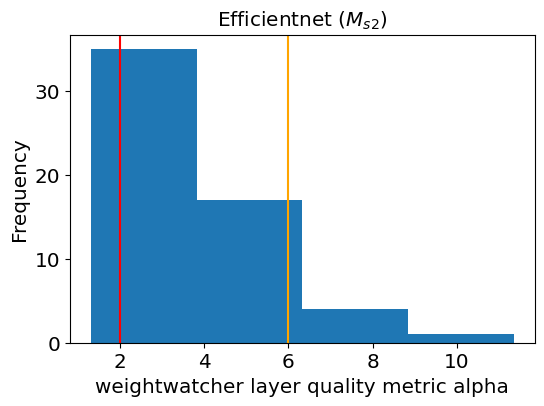

In [10]:
del_eff.alpha.plot.hist(bins=4, title='Efficientnet ($M_{s2}$)')
plt.xlabel("weightwatcher layer quality metric alpha")
plt.axvline(x=2.0, color='red')
plt.axvline(x=6.0, color='orange')
plt.savefig('effnet.alpha.png',bbox_inches='tight', dpi=150)

In [20]:
sum_res, del_res = res_analyze()
del_res.to_csv('details_res.csv')
sum_res

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 152MB/s] 


{'log_norm': 1.9124785038192829,
 'alpha': 3.469104554459105,
 'alpha_weighted': 0.4716515893343965,
 'log_alpha_norm': 1.1314091215888757,
 'log_spectral_norm': 0.17500931433254005,
 'stable_rank': 77.82423289564538}

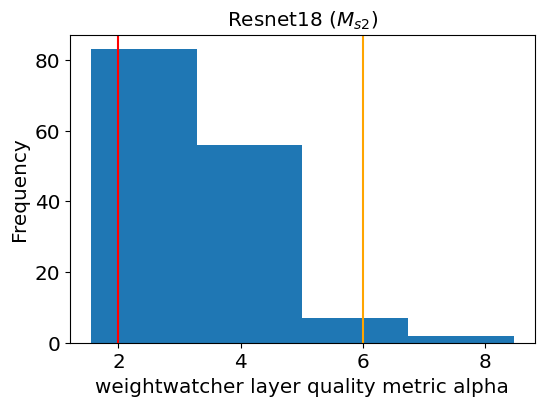

In [11]:
del_res.alpha.plot.hist(bins=4, title='Resnet18 ($M_{s2}$)')
plt.xlabel("weightwatcher layer quality metric alpha")
plt.axvline(x=2.0, color='red')
plt.axvline(x=6.0, color='orange')
plt.savefig('resnet.alpha.png',bbox_inches='tight', dpi=150)

In [29]:
del_res_1 = del_res[['longname', 'alpha', 'rank_loss', 'status', 'warning']]
del_eff_1 = del_eff[['longname', 'alpha', 'rank_loss', 'status', 'warning']]
del_eff_1.to_csv('eff_selected_detail.csv')
del_res_1.to_csv('res_selected_detail.csv')

# this is to use weightwatcher to tuned models

In [13]:
def retrain_model_eff1(name='', layid = 1):
    model_eff = _get_model_Eff()
    model_1 = _get_model_Eff()
    # retune the first one
    model_path= '/kaggle/input/tunedmodel/eff_combine_model_tune.pt'
    model_eff.load_state_dict(torch.load(model_path)) # , map_location='cpu'
    model_eff = change_parameters(model_1, model_eff)
       
    main_eff_retrain(model = model_eff, name=('model_eff1'+name), r_laye= layid)

In [12]:

def retrain_model_eff(name='', layid = 1):
    model1 =  _get_model_Eff()
    # Load model2 with custom weights
    model2 =  _get_model_Eff()  # Initialize with no pre-trained weights
    model2.load_state_dict(torch.load('/kaggle/input/tunedmodel/eff_combine_model_tune.pt'))

    # Freeze all parameters
    for param in model2.net.parameters():
        param.requires_grad = False
        
    model2 = change_parameters(model1, model2)
    
    # Collect parameters to tune (those from under-trained layers)
    params_to_tune = []

    for layer_name, status in layer_replacement_info.items():
            # Helper function to get submodule by name
        def get_submodule_by_name(model, name):
            for n, m in model.named_modules():
                if n == name:
                    return m
            return None
        # Get the submodule from model2
        layer_model2 = get_submodule_by_name(model2, layer_name) 
        # Collect the parameters from the layer
        if layer_model2 is not None:
            params_to_tune += list(layer_model2.parameters())
            
        layer_model2 = get_submodule_by_name(model2, layer_name)
        for param in layer_model2.parameters():
             param.requires_grad = True
#     print(params_to_tune)
    main_eff_retrain(model = model2, name=('model_eff1'+name), params_to_tune=params_to_tune)


In [125]:
retrain_model_eff(name='watcher', layid = 3)

Total number of batches in Train Loader: 164
Total number of batches in Val Loader: 35
Current accuracy is: 85.91%
Classification Report:
               precision    recall  f1-score   support

          nv       0.65      0.65      0.65        34
         mel       0.86      0.86      0.86        49
         bkl       0.68      0.73      0.70       109
         bcc       1.00      0.27      0.43        11
       akiec       0.96      0.91      0.93       811
        vasc       0.48      0.67      0.56        92
          df       0.83      1.00      0.91        15

    accuracy                           0.86      1121
   macro avg       0.78      0.73      0.72      1121
weighted avg       0.88      0.86      0.86      1121

Confusion Matrix:
 [[ 22   0   6   0   1   5   0]
 [  3  42   1   0   2   0   1]
 [  3   1  80   0  11  14   0]
 [  1   2   2   3   2   1   0]
 [  1   1  22   0 739  46   2]
 [  4   3   7   0  16  62   0]
 [  0   0   0   0   0   0  15]]
Epoch 0/0, Loss: 0.19651673

In [126]:
retrain_model_eff(name='watcher1', layid = 3)

Total number of batches in Train Loader: 164
Total number of batches in Val Loader: 35
Current accuracy is: 85.91%
Classification Report:
               precision    recall  f1-score   support

          nv       0.65      0.65      0.65        34
         mel       0.86      0.86      0.86        49
         bkl       0.68      0.73      0.70       109
         bcc       1.00      0.27      0.43        11
       akiec       0.96      0.91      0.93       811
        vasc       0.48      0.67      0.56        92
          df       0.83      1.00      0.91        15

    accuracy                           0.86      1121
   macro avg       0.78      0.73      0.72      1121
weighted avg       0.88      0.86      0.86      1121

Confusion Matrix:
 [[ 22   0   6   0   1   5   0]
 [  3  42   1   0   2   0   1]
 [  3   1  80   0  11  14   0]
 [  1   2   2   3   2   1   0]
 [  1   1  22   0 739  46   2]
 [  4   3   7   0  16  62   0]
 [  0   0   0   0   0   0  15]]
Epoch 0/0, Loss: 0.18552498

In [127]:
retrain_model_eff(name='watcher2', layid = 3)

Total number of batches in Train Loader: 164
Total number of batches in Val Loader: 35
Current accuracy is: 85.91%
Classification Report:
               precision    recall  f1-score   support

          nv       0.65      0.65      0.65        34
         mel       0.86      0.86      0.86        49
         bkl       0.68      0.73      0.70       109
         bcc       1.00      0.27      0.43        11
       akiec       0.96      0.91      0.93       811
        vasc       0.48      0.67      0.56        92
          df       0.83      1.00      0.91        15

    accuracy                           0.86      1121
   macro avg       0.78      0.73      0.72      1121
weighted avg       0.88      0.86      0.86      1121

Confusion Matrix:
 [[ 22   0   6   0   1   5   0]
 [  3  42   1   0   2   0   1]
 [  3   1  80   0  11  14   0]
 [  1   2   2   3   2   1   0]
 [  1   1  22   0 739  46   2]
 [  4   3   7   0  16  62   0]
 [  0   0   0   0   0   0  15]]
Epoch 0/0, Loss: 0.19484343

In [128]:
retrain_model_eff(name='watcher3', layid = 3)

Total number of batches in Train Loader: 164
Total number of batches in Val Loader: 35
Current accuracy is: 85.91%
Classification Report:
               precision    recall  f1-score   support

          nv       0.65      0.65      0.65        34
         mel       0.86      0.86      0.86        49
         bkl       0.68      0.73      0.70       109
         bcc       1.00      0.27      0.43        11
       akiec       0.96      0.91      0.93       811
        vasc       0.48      0.67      0.56        92
          df       0.83      1.00      0.91        15

    accuracy                           0.86      1121
   macro avg       0.78      0.73      0.72      1121
weighted avg       0.88      0.86      0.86      1121

Confusion Matrix:
 [[ 22   0   6   0   1   5   0]
 [  3  42   1   0   2   0   1]
 [  3   1  80   0  11  14   0]
 [  1   2   2   3   2   1   0]
 [  1   1  22   0 739  46   2]
 [  4   3   7   0  16  62   0]
 [  0   0   0   0   0   0  15]]
Epoch 0/0, Loss: 0.20896803

In [14]:
retrain_model_eff(name='watcher4', layid = 3)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 125MB/s] 


Total number of batches in Train Loader: 164
Total number of batches in Val Loader: 35
Current accuracy is: 85.91%
Classification Report:
               precision    recall  f1-score   support

          nv       0.65      0.65      0.65        34
         mel       0.86      0.86      0.86        49
         bkl       0.68      0.73      0.70       109
         bcc       1.00      0.27      0.43        11
       akiec       0.96      0.91      0.93       811
        vasc       0.48      0.67      0.56        92
          df       0.83      1.00      0.91        15

    accuracy                           0.86      1121
   macro avg       0.78      0.73      0.72      1121
weighted avg       0.88      0.86      0.86      1121

Confusion Matrix:
 [[ 22   0   6   0   1   5   0]
 [  3  42   1   0   2   0   1]
 [  3   1  80   0  11  14   0]
 [  1   2   2   3   2   1   0]
 [  1   1  22   0 739  46   2]
 [  4   3   7   0  16  62   0]
 [  0   0   0   0   0   0  15]]
Epoch 0/0, Loss: 0.20881807

In [15]:
retrain_model_eff(name='watcher5', layid = 3)

Total number of batches in Train Loader: 164
Total number of batches in Val Loader: 35
Current accuracy is: 85.91%
Classification Report:
               precision    recall  f1-score   support

          nv       0.65      0.65      0.65        34
         mel       0.86      0.86      0.86        49
         bkl       0.68      0.73      0.70       109
         bcc       1.00      0.27      0.43        11
       akiec       0.96      0.91      0.93       811
        vasc       0.48      0.67      0.56        92
          df       0.83      1.00      0.91        15

    accuracy                           0.86      1121
   macro avg       0.78      0.73      0.72      1121
weighted avg       0.88      0.86      0.86      1121

Confusion Matrix:
 [[ 22   0   6   0   1   5   0]
 [  3  42   1   0   2   0   1]
 [  3   1  80   0  11  14   0]
 [  1   2   2   3   2   1   0]
 [  1   1  22   0 739  46   2]
 [  4   3   7   0  16  62   0]
 [  0   0   0   0   0   0  15]]
Epoch 0/0, Loss: 0.19903595

In [16]:
retrain_model_eff(name='watcher6', layid = 3)

Total number of batches in Train Loader: 164
Total number of batches in Val Loader: 35
Current accuracy is: 85.91%
Classification Report:
               precision    recall  f1-score   support

          nv       0.65      0.65      0.65        34
         mel       0.86      0.86      0.86        49
         bkl       0.68      0.73      0.70       109
         bcc       1.00      0.27      0.43        11
       akiec       0.96      0.91      0.93       811
        vasc       0.48      0.67      0.56        92
          df       0.83      1.00      0.91        15

    accuracy                           0.86      1121
   macro avg       0.78      0.73      0.72      1121
weighted avg       0.88      0.86      0.86      1121

Confusion Matrix:
 [[ 22   0   6   0   1   5   0]
 [  3  42   1   0   2   0   1]
 [  3   1  80   0  11  14   0]
 [  1   2   2   3   2   1   0]
 [  1   1  22   0 739  46   2]
 [  4   3   7   0  16  62   0]
 [  0   0   0   0   0   0  15]]
Epoch 0/0, Loss: 0.20820344

In [17]:
retrain_model_eff(name='watcher7', layid = 3)

Total number of batches in Train Loader: 164
Total number of batches in Val Loader: 35
Current accuracy is: 85.91%
Classification Report:
               precision    recall  f1-score   support

          nv       0.65      0.65      0.65        34
         mel       0.86      0.86      0.86        49
         bkl       0.68      0.73      0.70       109
         bcc       1.00      0.27      0.43        11
       akiec       0.96      0.91      0.93       811
        vasc       0.48      0.67      0.56        92
          df       0.83      1.00      0.91        15

    accuracy                           0.86      1121
   macro avg       0.78      0.73      0.72      1121
weighted avg       0.88      0.86      0.86      1121

Confusion Matrix:
 [[ 22   0   6   0   1   5   0]
 [  3  42   1   0   2   0   1]
 [  3   1  80   0  11  14   0]
 [  1   2   2   3   2   1   0]
 [  1   1  22   0 739  46   2]
 [  4   3   7   0  16  62   0]
 [  0   0   0   0   0   0  15]]
Epoch 0/0, Loss: 0.18595268

In [18]:
retrain_model_eff(name='watcher8', layid = 3)

Total number of batches in Train Loader: 164
Total number of batches in Val Loader: 35
Current accuracy is: 85.91%
Classification Report:
               precision    recall  f1-score   support

          nv       0.65      0.65      0.65        34
         mel       0.86      0.86      0.86        49
         bkl       0.68      0.73      0.70       109
         bcc       1.00      0.27      0.43        11
       akiec       0.96      0.91      0.93       811
        vasc       0.48      0.67      0.56        92
          df       0.83      1.00      0.91        15

    accuracy                           0.86      1121
   macro avg       0.78      0.73      0.72      1121
weighted avg       0.88      0.86      0.86      1121

Confusion Matrix:
 [[ 22   0   6   0   1   5   0]
 [  3  42   1   0   2   0   1]
 [  3   1  80   0  11  14   0]
 [  1   2   2   3   2   1   0]
 [  1   1  22   0 739  46   2]
 [  4   3   7   0  16  62   0]
 [  0   0   0   0   0   0  15]]
Epoch 0/0, Loss: 0.19442427

In [19]:
retrain_model_eff(name='watcher9', layid = 3)

Total number of batches in Train Loader: 164
Total number of batches in Val Loader: 35
Current accuracy is: 85.91%
Classification Report:
               precision    recall  f1-score   support

          nv       0.65      0.65      0.65        34
         mel       0.86      0.86      0.86        49
         bkl       0.68      0.73      0.70       109
         bcc       1.00      0.27      0.43        11
       akiec       0.96      0.91      0.93       811
        vasc       0.48      0.67      0.56        92
          df       0.83      1.00      0.91        15

    accuracy                           0.86      1121
   macro avg       0.78      0.73      0.72      1121
weighted avg       0.88      0.86      0.86      1121

Confusion Matrix:
 [[ 22   0   6   0   1   5   0]
 [  3  42   1   0   2   0   1]
 [  3   1  80   0  11  14   0]
 [  1   2   2   3   2   1   0]
 [  1   1  22   0 739  46   2]
 [  4   3   7   0  16  62   0]
 [  0   0   0   0   0   0  15]]
Epoch 0/0, Loss: 0.18779352

In [20]:
retrain_model_eff(name='watcher10', layid = 3)

Total number of batches in Train Loader: 164
Total number of batches in Val Loader: 35
Current accuracy is: 85.91%
Classification Report:
               precision    recall  f1-score   support

          nv       0.65      0.65      0.65        34
         mel       0.86      0.86      0.86        49
         bkl       0.68      0.73      0.70       109
         bcc       1.00      0.27      0.43        11
       akiec       0.96      0.91      0.93       811
        vasc       0.48      0.67      0.56        92
          df       0.83      1.00      0.91        15

    accuracy                           0.86      1121
   macro avg       0.78      0.73      0.72      1121
weighted avg       0.88      0.86      0.86      1121

Confusion Matrix:
 [[ 22   0   6   0   1   5   0]
 [  3  42   1   0   2   0   1]
 [  3   1  80   0  11  14   0]
 [  1   2   2   3   2   1   0]
 [  1   1  22   0 739  46   2]
 [  4   3   7   0  16  62   0]
 [  0   0   0   0   0   0  15]]
Epoch 0/0, Loss: 0.19783331

In [11]:

    
layer_replacement_info = {
        'net.features.6.0.block.2.fc1': 'over-trained',
        'net.features.6.0.block.2.fc2': 'over-trained',
        'net.features.2.0.block.3.0': 'under-trained',
        'net.features.3.1.block.3.0': 'under-trained',
        'net.features.6.0.block.3.0': 'under-trained',
        'net.features.7.0.block.2.fc1': 'under-trained',
        'net.features.7.0.block.3.0': 'under-trained',
    }




def main_eff_retrain(model = None, name='test',params_to_tune=None):
    # Hyperparameters
    num_epochs_mlp = 1
    num_epochs_total = 10  # Total epochs including both MLP and U-Net
    learning_rate = 0.001
    BATCH_SIZE = 32

    # Now you can train the model on your dataset
    model = model.to('cuda' if torch.cuda.is_available() else 'cpu')
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
#   this is for tune only, 1 and 2, the follows is only tune 
      
    
#     optimizer = optim.Adam(model.net.features.7.0.block.2.fc.parameters(), lr=1e-4)
    optimizer = optim.Adam(params_to_tune, lr=1e-4)
    from torch.utils.data import DataLoader, WeightedRandomSampler
    from collections import Counter
    # Compute class weights for imbalanced dataset
    class_counts = Counter([label for label in train_df['cell_type_idx']])
    class_weights = {class_id: 1.0 / count for class_id, count in class_counts.items()}
    sample_weights = [class_weights[label] for label in train_df['cell_type_idx']]
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
    

    image_source = '/kaggle/input/skin-cancer-mnist-ham10000/'
    train_data = dataMedicalImage(train_df, image_folder= image_source, transform=transform_train)
    val_data = dataMedicalImage(val_df,image_folder= image_source,  transform=transform_val)
    test_data = dataMedicalImage(test_df, image_folder= image_source, transform=transform_val)
    
    # Data loaders
    trainloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, sampler=sampler)
    valloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
    testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

    print(f"Total number of batches in Train Loader: {len(trainloader)}")
    print(f"Total number of batches in Val Loader: {len(valloader)}")

    best_model = None
    accf = 0
    test_model(model, testloader)
    
    for epoch in range(0, num_epochs_total, 1):
        # Train MLP for 10 epochs
        model = train_model(model, trainloader, criterion, optimizer, num_epochs_mlp)

        acc = eval_model(model, valloader)
        if acc > accf:
            accf = acc
            best_model = model
            torch.save(best_model.state_dict(), 'retrain_eff_old_model_'+name+'.pt')
    test_model(best_model, testloader)
    

In [10]:
import torch
from torch import nn
from torchvision import models


def change_parameters(model1, model2):
    # Load model1 with pre-trained weights
    # model1 = models.efficientnet_b0(weights='DEFAULT')

    # # Load model2 with custom weights
    # model2 = models.efficientnet_b0(weights=None)  # Initialize with no pre-trained weights
    # model2.load_state_dict(torch.load('/eff_combine_model_tune.pt'))

    # Define the layers to replace and the layers to tune or freeze
    layer_replacement_info = {
        'net.features.6.0.block.2.fc1': 'over-trained',
        'net.features.6.0.block.2.fc2': 'over-trained',
        'net.features.2.0.block.3.0': 'under-trained',
        'net.features.3.1.block.3.0': 'under-trained',
        'net.features.6.0.block.3.0': 'under-trained',
        'net.features.7.0.block.2.fc1': 'under-trained',
        'net.features.7.0.block.3.0': 'under-trained',
    }

    # Helper function to get submodule by name
    def get_submodule_by_name(model, name):
        for n, m in model.named_modules():
            if n == name:
#                 print('--',n)
                return m
        return None

    # Replace weights and set parameters
    for layer_name, status in layer_replacement_info.items():
        # Remove 'net.' prefix for module lookup
#         cleaned_layer_name = layer_name.replace('net.', '')

        # Get the layers from both models
        layer_model1 = get_submodule_by_name(model1, layer_name)
        layer_model2 = get_submodule_by_name(model2, layer_name)
#         print(layer_model1)
#         print(layer_model2)
        if status == 'over-trained':
            # Replace the weights of model2 with model1's weights for over-trained layers
            if layer_model1 is not None and layer_model2 is not None:
                layer_model2.load_state_dict(layer_model1.state_dict())
            # Freeze the parameters of the over-trained layers in model2
            for param in layer_model2.parameters():
                param.requires_grad = True
        elif status == 'under-trained':
            # Make sure the parameters are trainable for under-trained layers in model2
            if layer_model2 is not None:
                for param in layer_model2.parameters():
                    param.requires_grad = True

    # Now model2 has weights replaced for over-trained layers and appropriate layers frozen or unfrozen.
    return model2

In [113]:
model_eff = change_parameters(model1, model2)

-- net.features.6.0.block.2.fc1
-- net.features.6.0.block.2.fc1
Conv2d(672, 28, kernel_size=(1, 1), stride=(1, 1))
Conv2d(672, 28, kernel_size=(1, 1), stride=(1, 1))
-- net.features.6.0.block.2.fc2
-- net.features.6.0.block.2.fc2
Conv2d(28, 672, kernel_size=(1, 1), stride=(1, 1))
Conv2d(28, 672, kernel_size=(1, 1), stride=(1, 1))
-- net.features.2.0.block.3.0
-- net.features.2.0.block.3.0
Conv2d(96, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
Conv2d(96, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
-- net.features.3.1.block.3.0
-- net.features.3.1.block.3.0
Conv2d(240, 40, kernel_size=(1, 1), stride=(1, 1), bias=False)
Conv2d(240, 40, kernel_size=(1, 1), stride=(1, 1), bias=False)
-- net.features.6.0.block.3.0
-- net.features.6.0.block.3.0
Conv2d(672, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
Conv2d(672, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
-- net.features.7.0.block.2.fc1
-- net.features.7.0.block.2.fc1
Conv2d(1152, 48, kernel_size=(1, 1), stride=(1

# pie-chart plots- (
Assignment 2 or skin-cancer-pie-chart)

In [ ]:
!pip install torchinfo

import pandas as pd
import numpy as np
import torch
import os
import shutil
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import Dataset, WeightedRandomSampler, DataLoader, Subset
from transformers import ConvNextForImageClassification
from torchvision.transforms.functional import to_pil_image
from torchvision import transforms
from torchinfo import summary
from PIL import Image


In [ ]:
# Define a function to combine images in different folders into 1 folders
def combine_folders(src1, src2, dest):

    copied_files = []  # List to store names of successfully copied files

    # Create folder when destination folder not exist, exit function if destination folder contains contents from the source folder
    if not os.path.exists(dest):
      print(f"Destination folder {dest} created...")
      os.makedirs(dest)

    else:
      # Recreate folder when destination folder do not have all the contents in source folders to avoid overlapping contents
      if len(os.listdir(dest)) == (len(os.listdir(src1)) + len(os.listdir(src2))):
        print("Content in source 1 folder and source 2 folder have been copied to destination folder")

        for filename in os.listdir(dest):
            copied_files.append(filename)

        return copied_files

      else:
        shutil.rmtree(dest)
        os.makedirs(dest)


    print(f"Copying images in {src1} into {dest}...")

    # Loop through all content in source folder 1 and copy into destination folder, if source 1 folder exist
    if os.path.exists(src1):
      print('Source 1 folder consist of ', len(os.listdir(src1)), " elements")

      for images in os.listdir(src1):

        # Define the source path and the destination path for each images
        src_path = os.path.join(src1, images)
        dest_path = os.path.join(dest, images)

        # Copy to the destination folder
        shutil.copy(src_path, dest_path)
        copied_files.append(images)

      print(f"All images in {src1} have been copied into {dest}...")

    else:
      print(f"{src1} not found")


    print(f"Copying images in {src2} into {dest}...")

    # loop through all content in source folder 2 and copy into destination folder, if source 2 folder exist
    if os.path.exists(src2):
      print('Source 2 folder consist of ', len(os.listdir(src2)), " elements")

      for images in os.listdir(src2):

        # Define the source path and the destination path for each images
        src_path = os.path.join(src2, images)
        dest_path = os.path.join(dest, images)

        # Copy to the destination folder
        shutil.copy(src_path, dest_path)
        copied_files.append(images)

      print(f"All images in {src2} have been copied into {dest}...")

    else:
      print(f"{src2} not found")

    print('Destination folder consist of ', len(os.listdir(dest)), " elements")

    return copied_files

In [ ]:
# Source directory
import shutil

source_dir = "/kaggle/input/skin-cancer-mnist-ham10000"

# Destination directory
destination_dir = "/kaggle/working/Dataset"

shutil.copytree(source_dir, destination_dir)
# Define source paths to combined and destination path to store
src1 = "/kaggle/working/Dataset/HAM10000_images_part_1/"
src2 = "/kaggle/working/Dataset/HAM10000_images_part_2/"
dest = "/kaggle/working/Dataset/HAM10000/"
copied_files = combine_folders(src1, src2, dest)

In [ ]:
train_file = "Dataset/HAM10000_metadata.csv"
skin_train_df = pd.read_csv(train_file)

skin_train_df['image_id_with_extension'] = skin_train_df['image_id'] + '.jpg'
skin_train_df = skin_train_df[skin_train_df['image_id_with_extension'].isin(copied_files)]
skin_train_df = skin_train_df.drop(columns=['image_id_with_extension'])

skin_train_df.head(5)

In [ ]:
# Dictionary to map lesion type codes to their full names
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [ ]:

# Filter out the 'nv' category if it exists
filtered_df = skin_train_df[skin_train_df['dx'] != 'nv']


import matplotlib.pyplot as plt
# Group by 'dx' and 'localization' and then count the occurrences
grouped_counts = filtered_df.groupby(['localization', 'dx']).size().reset_index(name='count')

# Get unique localization categories
localizations = grouped_counts['localization'].unique()
# Define a fixed color map for each lesion type (dx)
color_map = {
    'mel': '#1f77b4',  # Blue
    'bkl': '#ff7f0e',  # Orange
    'bcc': '#2ca02c',  # Green
    'akiec': '#d62728',  # Red
    'vasc': '#9467bd',  # Purple
    'df': '#8c564b',    # Brown
    'nv': '#8c7e4b',
}

# Loop over each localization and save each pie chart as a separate PNG file
for i, localization in enumerate(localizations):
    # Filter data for the current localization
    loc_data = grouped_counts[grouped_counts['localization'] == localization]
    
    # Map the 'dx' values using the lesion_type_dict for the labels
    labels = loc_data['dx'].map(lesion_type_dict)
    
    # Create a list of colors for the current dx values using the fixed color_map
    colors = [color_map[dx] for dx in loc_data['dx']]
    print(colors, loc_data)
    # Create a new figure for each pie chart
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # Pie chart without labels, using the predefined colors
    wedges, texts, autotexts = ax.pie(
        loc_data['count'], autopct='%1.1f%%', startangle=90, colors=colors
    )
    
    # Set title for the pie chart
    ax.set_title(f'Lesion Type-[{localization.capitalize()}]')
    
    # Ensure the pie is drawn as a circle
    ax.set_aspect('equal')

    # Create a custom legend
    legend_entries = [f"{label}: {count}" for label, count in zip(labels, loc_data['count'])]
    
    # Display the legend outside the chart
    ax.legend(wedges, legend_entries, title="Lesion Type", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=14, frameon=False)
    
    # Save the figure as a PNG file
    plt.savefig(f'pie_chart_{localization}.png', bbox_inches='tight')
    
    # Close the figure to free up memory
    plt.close()


In [ ]:
skin_train_df['localization'].unique()

download the test folder data

In [3]:
test_df = pd.read_csv('/kaggle/input/ucidatasplits/test_df.csv').drop(columns=['Unnamed: 0'])
test_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0001359,ISIC_0028628,bkl,histo,75.0,male,lower extremity,data\HAM10000_images_part_1\ISIC_0028628.jpg,Benign keratosis-like lesions,2
1,HAM_0003188,ISIC_0030765,nv,histo,30.0,female,abdomen,data\HAM10000_images_part_2\ISIC_0030765.jpg,Melanocytic nevi,4
2,HAM_0005275,ISIC_0028749,bkl,histo,65.0,male,face,data\HAM10000_images_part_1\ISIC_0028749.jpg,Benign keratosis-like lesions,2
3,HAM_0001061,ISIC_0029526,nv,follow_up,45.0,male,back,data\HAM10000_images_part_2\ISIC_0029526.jpg,Melanocytic nevi,4
4,HAM_0003249,ISIC_0025114,nv,follow_up,35.0,male,back,data\HAM10000_images_part_1\ISIC_0025114.jpg,Melanocytic nevi,4


In [10]:
test_df['image'] = test_df['path'].map(lambda x: (x[5:27]+'/'+x[-16:]))
test_df.head(1) 

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0001359,ISIC_0028628,bkl,histo,75.0,male,lower extremity,data\HAM10000_images_part_1\ISIC_0028628.jpg,Benign keratosis-like lesions,2,HAM10000_images_part_1/ISIC_0028628.jpg


In [15]:
import os
import shutil

# Define source and destination directories
source_folder = "/kaggle/input/skin-cancer-mnist-ham10000/"
destination_folder = "/kaggle/working/testdata/"

# Ensure destination folder exists
os.makedirs(destination_folder, exist_ok=True)

# Iterate through the 'image' column in result_df
for image_name in test_df['image']:
    # Construct full file paths
    source_path = os.path.join(source_folder, image_name)  # Assuming files have .jpg extension
    destination_path = os.path.join(destination_folder, image_name[-16:])
    
    # Copy file if it exists in the source folder
    if os.path.exists(source_path):
        shutil.copy(source_path, destination_path)
    else:
        print(f"File not found: {source_path}")


In [17]:
# Create a zip archive
output_zip_file = "to_testfolder.zip"
shutil.make_archive(base_name=output_zip_file.replace('.zip', ''), format='zip', root_dir='/kaggle/working/testdata')

'/kaggle/working/to_testfolder.zip'